In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759566 sha256=b975d0a96220a7987a475485aae9b55e76b8fa6c057da0b4f0506819dd0eae94
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhvs56ex/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
     |████████████████████████████████| 256kB 3.0MB/s 
  ERROR: Cannot unpack file /tmp/pip-unpack-zb01hs7q/matplotlib-toolkits (downloaded 

In [ ]:
!pip install netcdf4
!pip install pyMCR
!pip install geopandas

# Libraries

In [ ]:
#!/bin/env python
import sys
import glob
import os
import numpy as np
import numpy.ma as ma
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import torch
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import measure, transform
from scipy.ndimage import label
from scipy.spatial import distance
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, LinearRing, MultiPoint
from descartes import PolygonPatch
import networkx as nx
import tarfile
import string
import calendar
import cv2
from google.colab.patches import cv2_imshow
from mpl_toolkits.basemap import Basemap,cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
from geopandas import GeoSeries

In [ ]:
DIR = '/content/drive/MyDrive/StageUParis/DATA/H2O/'
DIR_TEST = '/content/drive/MyDrive/StageUParis/Test/'

# Functions

In [ ]:
def plot_original_data(DIR, year, month, day, type_image, hasCoastLines=False):

    # lat and lon at 0.25 degree resolution
    latg = np.arange(20., 50., 0.25)
    long = np.arange(100., 150., 0.25)

    for year in range(year, year + 1):
        for month in range(month, month + 1):
            ndays = calendar.mdays[month] + (month == 2 and calendar.isleap(year))
            print(year, month, ndays)
            #  for dd in range (1,ndays+1):
            for dd in range(day, day + 1):
                print(dd)
                # initialization
                colgrid = np.zeros([latg.shape[0], long.shape[0]])
                fname = DIR+'IASIdaily_'+str(year)+"%02d" % month+"%02d" % dd+'.nc'
                print(fname)
                # read IASI data in nc archive
                if not(os.path.isfile(fname)):
                    continue
                nc = netCDF4.Dataset(fname)
                flg = nc.variables['flag'][:]
                mask1 = (flg == 0)
                lat = nc.variables['lat'][mask1]
                lon = nc.variables['lon'][mask1]
                col = nc.variables[type_image][mask1]
                nc.close()
                print('end read nc')

                mask2 = (np.isnan(col) == False)
                
                # gridding the data
                for ilat in range(latg.shape[0]):
                    for ilon in range(long.shape[0]):
                        maskgrid = (lat[:] >= (latg[ilat]-0.125)) & (lat[:] < (latg[ilat]+0.125)) & (
                            lon[:] >= (long[ilon]-0.125)) & (lon[:] < (long[ilon]+0.125))
                        mask = mask2 & maskgrid
                        if len(col[mask]) != 0:
                            colgrid[ilat, ilon] = np.mean(col[mask])
                colgrid = ma.masked_values(colgrid, 0.)
                
                # plot daily maps
                fig = plt.figure(figsize=(11, 8))
                plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9)
                
                # ------ subplot : IASI LT col
                ax = fig.add_subplot(111)
                p1 = plt.subplot(1, 1, 1)
                
                # to have coastline and countries in the background of the image
                if hasCoastLines:
                    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
                    m.drawcoastlines()
                    m.drawmapboundary()
                    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
                    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

                # ,cmap=plt.cm.Greys)
                cs = plt.pcolor(long, latg, colgrid, vmin=7, vmax=30, cmap="jet")
                c = plt.colorbar(cs)  # ,location='bottom',pad="10%")
                c.set_label("[DU]", fontsize=10)
                c.ax.tick_params(labelsize=8)
                sbpt = "IASI LT ozone column "+str(year)+"%02d" % month+"%02d" % dd
                plt.title(sbpt, fontsize=10)

                figname = "Daily_IASI_gridded_raw." + \
                    str(year)+"%02d" % month+"%02d" % dd+".png"
                    
                #   figname="Daily_IASI_gridded_grey_raw."+str(year)+"%02d"%month+"%02d"%dd+".png"
                print(figname)
                plt.savefig(figname)
        print('end month')

In [ ]:
def plot_initial_data (DIR, year, month, day, image_type, degree, image_name, vmax):  
  lat_g = np.arange(20.,50.,degree)
  lon_g = np.arange(100.,150.,degree)

  #initialization
  colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

  for year in range(year,year + 1):
    for month in range(month,month + 1):
      ndays = calendar.mdays[month] + (month==2 and calendar.isleap(year))
      print(year,month,ndays)

      for dd in range (day,day+1):
        
        fname = DIR + 'IASIdaily_' + str(year) + "%02d"%month + "%02d"%dd + '.nc'

        #read IASI data in nc archive
        if not(os.path.isfile(fname)):
          continue

        nc = netCDF4.Dataset(fname)
        flg = nc.variables['flag'][:]
        mask1 = (flg == 0)
        
        lat = nc.variables['lat'][mask1]
        lon = nc.variables['lon'][mask1]
        col = nc.variables[image_type][mask1]
        nc.close()

        print('end read nc')
        mask2 = (np.isnan(col) == False) 

        # gridding the data
        for ilat in range(lat_g.shape[0]):
          for ilon in range(lon_g.shape[0]):
            # Grille régulier
            # 25 km
            # 0 25 degrée lattitude et longitude

            # Grille regulier of 0.125 degree
            maskgrid = (lat[:] >= (lat_g[ilat] - size)) & (lat[:] < (lat_g[ilat] + size)) & (lon[:] >= (lon_g[ilon] - size)) & (lon[:] < (lon_g[ilon] + size))
            
            # Defining invalid data
            mask = mask2 & maskgrid

            if len(col[mask]) != 0:
              median = np.mean(col[mask])
              colgrid[ilat,ilon] = median

        # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
        colgrid1 = ma.masked_values(colgrid, 0.)

        v_x, v_y = np.meshgrid(lon_g, lat_g)

        fig2, (f2ax1) = plt.subplots(1, 1, figsize = (11,8))
        f2ax1.pcolormesh(v_x, v_y, colgrid1, shading='nearest',cmap='jet', vmin=colgrid.min(), vmax=vmax)
        f2ax1.axis('off')
        fig2.savefig(image_name, bbox_inches='tight', pad_inches=0)


  return v_x,v_y,colgrid1

def plot_original_image(v_x,v_y,colgrid,vmax=35):
  #Plot the original
  fig1, (f1ax1) = plt.subplots(1, 1, figsize = (11,8))
  divider = make_axes_locatable(f1ax1)
  cax = divider.append_axes('right', size='1%', pad=0.05)
  colorinfo = f1ax1.pcolormesh(v_x, v_y, colgrid, shading='nearest',cmap='jet', vmin=colgrid.min(), vmax=vmax)
  fig1.colorbar(colorinfo, cax=cax)

In [ ]:
def set_image_to_opencv (colgrid):
  data = np.full((colgrid.shape[0], colgrid.shape[1]), colgrid, np.uint8)
  img_bgr = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
  img_rgb = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
  gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
  return img_rgb, gray

def load_image_from_files (image_name):
  img_rgb = cv2.imread(image_name, cv2.IMREAD_ANYCOLOR)
  img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
  gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
  return img_rgb,img_bgr, gray

In [ ]:
def get_mser_regions(image_mser, max_area = 50000, min_area = 5000):
  mser = cv2.MSER_create()
  mser.setMaxArea(max_area)
  mser.setMinArea(min_area)

  regions, bboxes = mser.detectRegions(image_mser)
  regions = sorted(regions, key=cv2.contourArea, reverse=True)

  return regions, bboxes

In [ ]:
def find_regions_mser (colgrid, gray):
  #gradx, grady = np.gradient(colgrid, edge_order=1)

  ### SCALE
  scale_percent = 100 #200 # percent of original size
  width = int(gray.shape[1] * scale_percent / 100)
  height = int(gray.shape[0] * scale_percent / 100)
  dim = (width, height)
  gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)
  #gray = cv2.normalize(gray, np.ones((gray.shape[0], gray.shape[0])) , 0, 255, cv2.NORM_MINMAX )

  ### MORPHO FILTERS
  kernel = np.ones((3,3),np.uint8)
  closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations = 3)
  image_close = closing.copy()

  ## REMOVING THE HOLES
  image_large_close = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8), iterations = 3)
  image_holes = image_close.copy()
  
  # Take the holes (pixels value = 0) and set it as 255
  image_holes = np.where(image_holes == 0, 255, image_holes) 
  image_holes = np.where(image_holes != 255, 0, image_holes) # This is the mask of the background
  image_holes_dilate = cv2.morphologyEx(image_holes, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 3)
  image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground 

  gray = image_close.copy()

  ## Below code convert image gradient in both x and y direction
  image_laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=3) 
  image_laplacian = np.uint8(np.absolute(image_laplacian))
  #image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

  ## Below code convert image gradient in x direction
  sobelx= cv2.Sobel(gray, 0, dx=1,dy=0)
  sobelx= np.uint8(np.absolute(sobelx))
  ## Below code convert image gradient in y direction
  sobely= cv2.Sobel(gray, 0, dx=0,dy=1)
  sobely = np.uint8(np.absolute(sobely))

  image_contour = image_laplacian.copy()
  edge = cv2.Canny(image_contour, colgrid.min(), colgrid.max())

  contours, h = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  for c in contours:
    hull = cv2.convexHull(c)
    cv2.drawContours(image_contour, [hull], 0, (255,255, 255), 1)

  #Create MSER object
  image_mser = gray.copy()
  image_mser = cv2.cvtColor(image_mser, cv2.COLOR_GRAY2RGB)
  regions, bboxes = get_mser_regions(image_mser, 50000, 5000)

  for p in regions:
    for k in p:
      cv2.circle(image_mser, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

  image_mser = cv2.bitwise_and(image_mser,image_mser,mask = image_holes_dilate_inv )

  _, labels, _, _ = cv2.connectedComponentsWithStats(image_laplacian, connectivity=8, ltype=cv2.CV_32S) 

  # Map component labels to hue val
  label_hue = np.uint8(170 * labels/np.max(labels))
  blank_ch = 255*np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

  # cvt to BGR for display
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

  # set bg label to black
  labeled_img[label_hue==0] = 0

  global_initial_gray = gray.copy()

  return image_laplacian , image_mser, image_holes_dilate_inv , regions


In [ ]:
def set_mser_regions(colgrid, gray, regions):
  temp_image = colgrid.copy()
  background_image = gray.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)

  regsX = list()
  regsY = list()
  regsPoly = list()

  for j,r in enumerate(regions):
    region = list()
    hull = cv2.convexHull(r)

    for h in hull:
        region.append(h[0].tolist())

    region.append(region[0])
    poly = Polygon(region)

    line = LineString(region)
    x, y = line.xy

    coord_x = int(line.centroid.x)
    coord_y = int(line.centroid.y)

    value_pixel = temp_image[coord_y, coord_x]

    xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]

    regsX.append(xs)
    regsY.append(ys)
    regsPoly.append(poly)
  
  return regsX, regsY, regsPoly

In [ ]:
def plot_mser_final_regions (gray, regsX, regsY):
  xrange = [0, gray.shape[1]]
  yrange = [0, gray.shape[0]]

  fig, ax = plt.subplots(1,1)

  for i in range(len(regsX)):
    ax.scatter(regsX[i] ,regsY[i], marker='.')
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.invert_yaxis()

In [ ]:
def plot_mser_regions(gray, regions):
  temp_image = gray.copy()
  background_image = gray.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)

  fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

  for j,r in enumerate(regions):
    region = list()
    hull = cv2.convexHull(r)

    for h in hull:
        region.append(h[0].tolist())

    region.append(region[0])
    poly = Polygon(region)

    line = LineString(region)
    x, y = line.xy

    coord_x = int(line.centroid.x)
    coord_y = int(line.centroid.y)

    value_pixel = temp_image[coord_y, coord_x]

    xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]

    xrange = [0, gray.shape[1]]
    yrange = [0, gray.shape[0]]

    ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
    ax0.set_xlim(*xrange)
    ax0.set_ylim(*yrange)
    ax0.set_title('Region ')
    ax0.invert_yaxis()
    #ax0.legend()

    ax1.plot(x, y, label='Region ' + str(j))
    ax1.set_xlim(*xrange)
    ax1.set_ylim(*yrange)
    ax1.set_title('ConvexHull ')
    ax1.invert_yaxis()
    ax1.legend()

    #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
    #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
    #ax = gs.plot(marker='.', color='red', markersize=1)
    #ax.set_xlim(*xrange)
    #ax.set_ylim(*yrange)

In [ ]:
def plot_mser_regions_3d(colgrid, gray, regions):
  temp_image = colgrid.copy()
  background_image = gray.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)
    
  fig3 = plt.figure(figsize =(14, 9))
  ax = plt.axes(projection ='3d')

  for j,r in enumerate(regions):
    region = list()
    hull = cv2.convexHull(r)

    for h in hull:
        region.append(h[0].tolist())

    region.append(region[0])
    poly = Polygon(region)

    line = LineString(region)
    x, y = line.xy

    coord_x = int(line.centroid.x)
    coord_y = int(line.centroid.y)

    value_pixel = temp_image[coord_y, coord_x]
    z = np.full(len(x),value_pixel)

    xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    zs = np.full(len(xs),value_pixel)  #    [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

    xrange = [0, gray.shape[1]]
    yrange = [0, gray.shape[0]]
    zrange = [0, temp_image.max()]

    ax.scatter(xs,ys,zs, marker='.')
    ax.set_zlim(*zrange)
    ax.invert_yaxis()
    

In [ ]:
def plot_image_gray_3d(gray):
  perspective = gray.copy()

  R = np.where(perspective != 0, perspective, np.nan)

  # create the x and y coordinate arrays (here we just use pixel indices)
  xx, yy = np.mgrid[0:perspective.shape[0], 0:perspective.shape[1]]

  fig = plt.figure(figsize = (11,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(xx, yy, R, rstride=1, linewidth=0)
  fig.show()

def plot_image_gray(img_rgb):
  test_gray_1 = img_rgb.copy()
  test_gray_1 = cv2.cvtColor(test_gray_1, cv2.COLOR_RGB2GRAY)
  print(test_gray_1.shape)
  #test_gray_1 = cv2.normalize(test_gray_1, np.ones(test_gray_1.shape , 0, 255, cv2.NORM_MINMAX ))
  test_gray_1 = cv2.normalize(test_gray_1, np.ones((test_gray_1.shape[0], test_gray_1.shape[1])) , 0, 255, cv2.NORM_MINMAX )

  fig1, (f1ax1) = plt.subplots(1, 1, figsize = (11,8))
  divider = make_axes_locatable(f1ax1)
  cax = divider.append_axes('right', size='2%', pad=0.05)
  colorinfo = f1ax1.imshow(test_gray_1, cmap="gray")
  #f1ax1.invert_yaxis()
  fig1.colorbar(colorinfo, cax=cax)

# UT IMAGE

In [ ]:
deg = .125
size1 = .0625

## LOOP
start = 1
end = 20

# Dates
day = 6
image_type="UT"
year=2008
month=5

degree = 0.625 # deg * i
size = 0.3125 # (degree * size1) /  deg
image_name = image_type+"-mesh-"+str(year)+"%02d"%month+"%02d"%day+".png"
vmax = 45

## THRESH
global_regions = []
global_contours = []
global_mser = []
global_laplacian = []
global_thresh = 40
global_trhesh_step = 3
global_thresh_down = global_thresh - global_trhesh_step
global_thresh_condition = False

2008 5 31
6
/content/drive/MyDrive/StageUParis/DATA/H2O/IASIdaily_20080506.nc
end read nc


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Daily_IASI_gridded_raw.20080506.png
end month
2008 5 31
end read nc


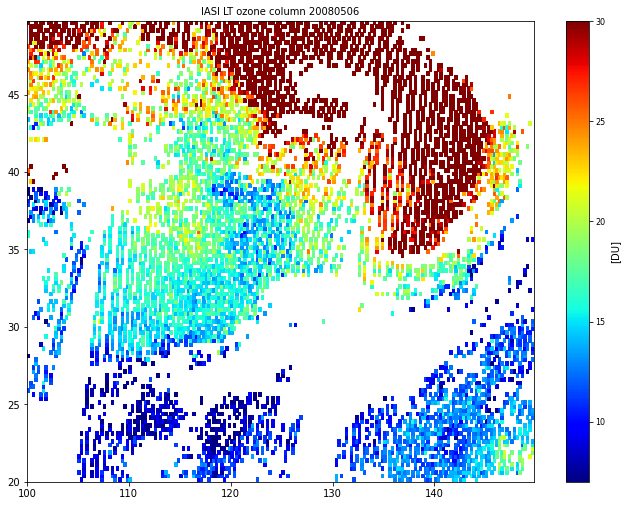

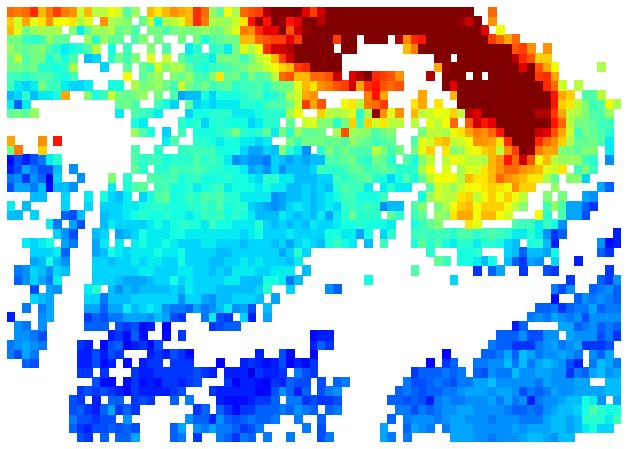

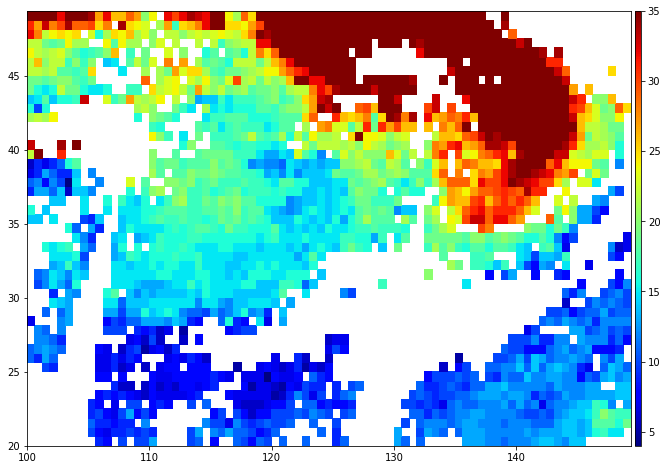

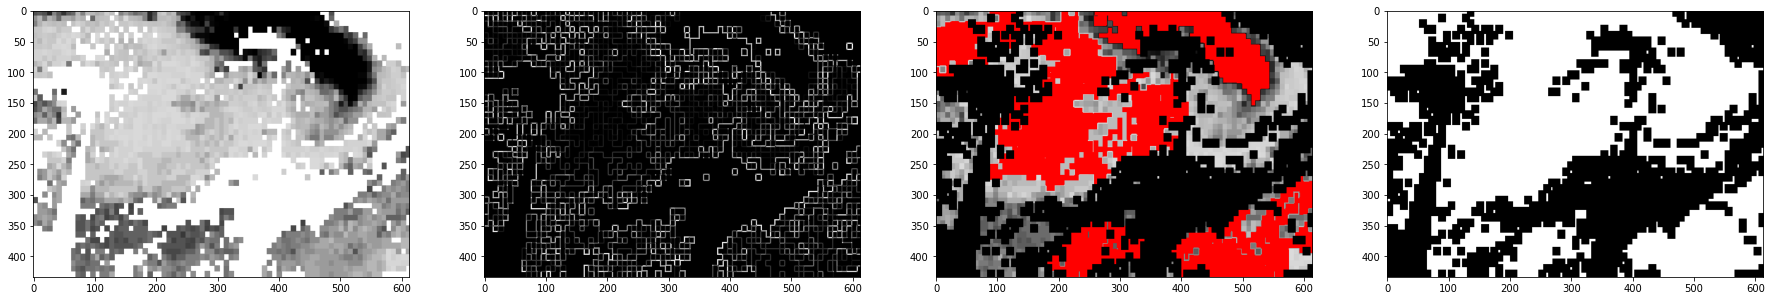

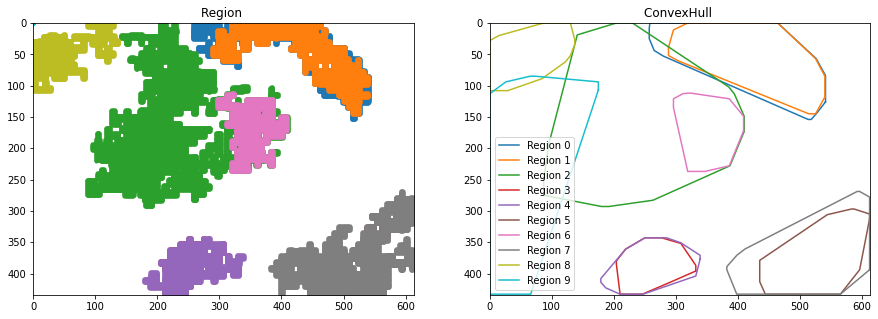

In [ ]:
plot_original_data(DIR,year,month,day,image_type)
v_x,v_y,colgrid_ut = plot_initial_data(DIR, year, month, day, image_type, degree, image_name, vmax)
plot_original_image(v_x,v_y,colgrid_ut)
### TO OPENCV
_, img_bgr, gray = load_image_from_files(image_name)

image_laplacian,image_mser,image_holes_dilate_inv,regions_ut = find_regions_mser (colgrid_ut, gray)

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(31,20))
ax0.imshow(gray, cmap="gray")
ax1.imshow(image_laplacian, cmap="gray")
ax2.imshow(image_mser)
ax3.imshow(image_holes_dilate_inv, cmap="gray")
plot_mser_regions(gray,regions_ut)

# LT IMAGE

In [ ]:
deg = .125
size1 = .0625

## LOOP
start = 1
end = 20

# Dates
day = 6
image_type="LT"
year=2008
month=5

degree = 0.625 # deg * i
size = 0.3125 # (degree * size1) /  deg
image_name = image_type+"-mesh-"+str(year)+"%02d"%month+"%02d"%day+".png"
vmax = 35

## THRESH
global_regions = []
global_contours = []
global_mser = []
global_laplacian = []
global_thresh = 40
global_trhesh_step = 3
global_thresh_down = global_thresh - global_trhesh_step
global_thresh_condition = False

2008 5 31
6
/content/drive/MyDrive/StageUParis/DATA/H2O/IASIdaily_20080506.nc
end read nc


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Daily_IASI_gridded_raw.20080506.png
end month
2008 5 31
end read nc


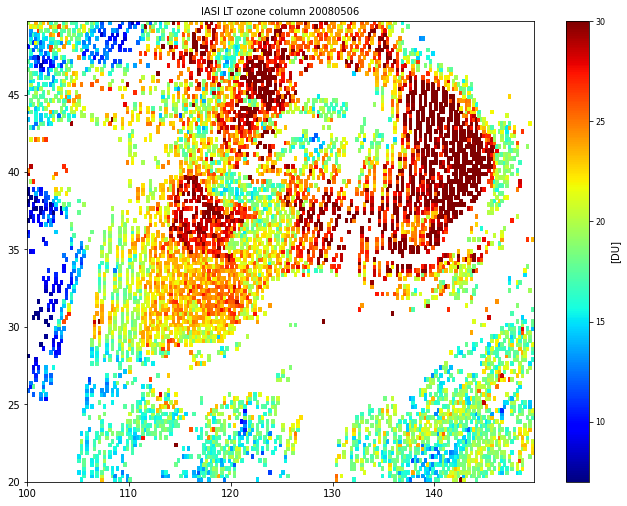

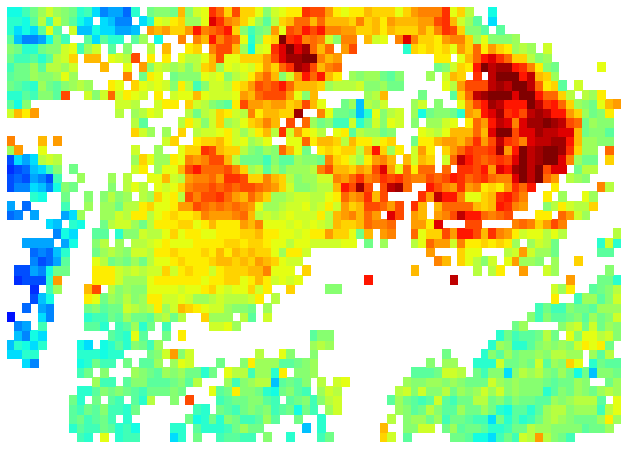

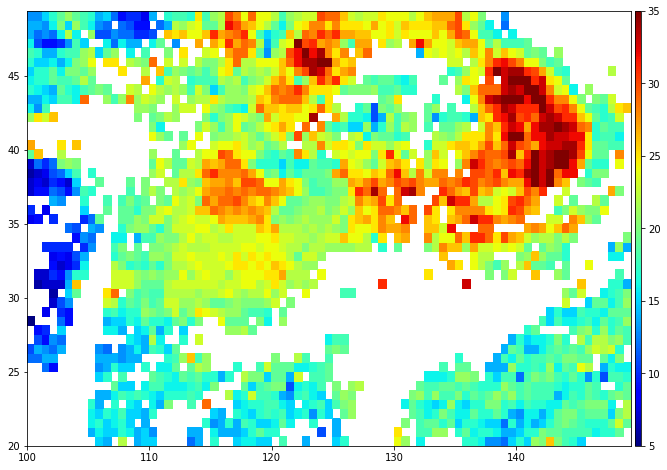

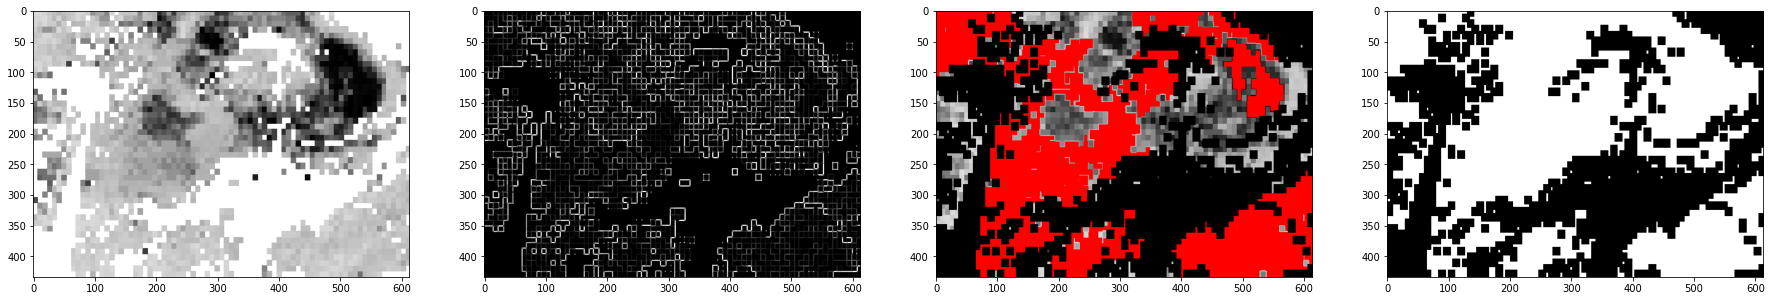

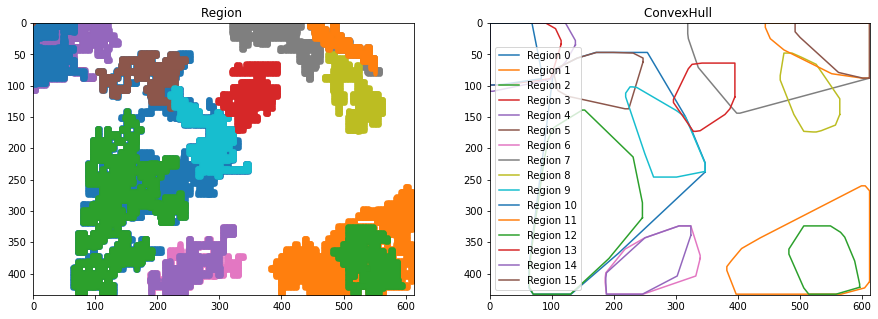

In [ ]:
plot_original_data(DIR,year,month,day,image_type)

v_x,v_y,colgrid_lt = plot_initial_data(DIR, year, month, day, image_type, degree, image_name, vmax)

plot_original_image(v_x,v_y,colgrid_lt)
### TO OPENCV
_, img_bgr , gray = load_image_from_files(image_name)

image_laplacian,image_mser,image_holes_dilate_inv ,regions_lt = find_regions_mser (colgrid_lt, gray)

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(31,20))
ax0.imshow(gray, cmap="gray")
ax1.imshow(image_laplacian, cmap="gray")
ax2.imshow(image_mser)
ax3.imshow(image_holes_dilate_inv, cmap="gray")
plot_mser_regions(gray,regions_lt)

# ORIGINAL MSER

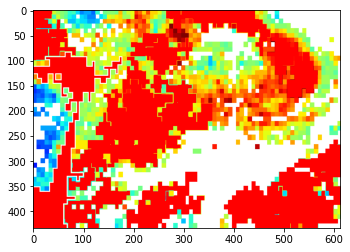

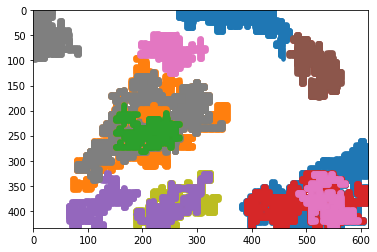

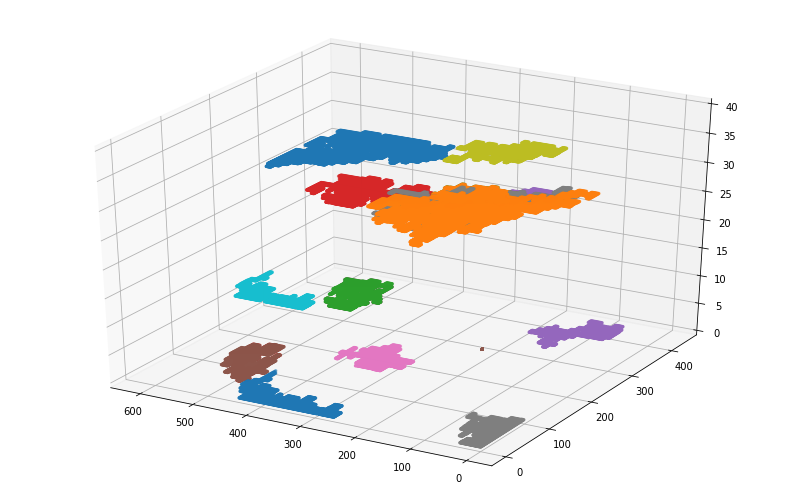

In [ ]:
### COMPARING MSER WITH ORIGINAL IMAGE

test = img_bgr.copy()

r,b = get_mser_regions(test)

for p in r:
    for k in p:
      cv2.circle(test, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

plt.imshow(test)

_, temp_gray = set_image_to_opencv(colgrid_lt)
dim = (gray.shape[1], gray.shape[0])
temp_gray = cv2.resize(temp_gray, dim, interpolation = cv2.INTER_AREA)

lt_regsX, lt_regsY, lt_polys = set_mser_regions(temp_gray,gray,r)
plot_mser_final_regions(gray,lt_regsX,lt_regsY)
plot_mser_regions_3d(temp_gray,gray,r)

# CARBON MONOXIDE

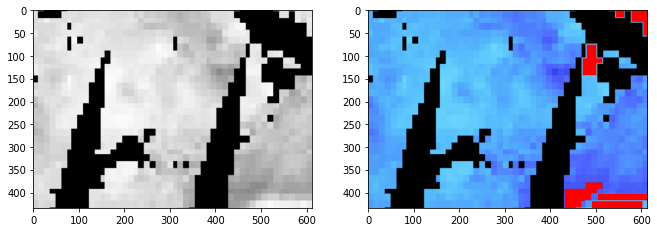

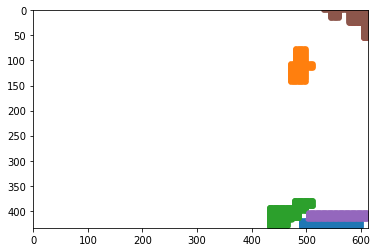

In [ ]:
### CO IMAGE

co_image = cv2.imread('snapshot-2008-05-0'+str(day)+'T00_00_00Z.png', cv2.IMREAD_ANYCOLOR)
dim = (gray.shape[1], gray.shape[0])
co_image = cv2.resize(co_image, dim, interpolation = cv2.INTER_AREA)
co_gray = cv2.cvtColor(co_image, cv2.COLOR_BGR2GRAY)

test2 = co_image.copy()
r,b = get_mser_regions(test2, 10000, 1000)

for p in r:
    for k in p:
      cv2.circle(test2, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,8))
ax1.imshow(co_gray, cmap="gray")
ax2.imshow(test2)

temp_gray = cv2.resize(co_gray, dim, interpolation = cv2.INTER_AREA)
co_regsX, co_regsY, co_polys = set_mser_regions(co_image,co_gray,r)
plot_mser_final_regions(co_gray,co_regsX,co_regsY)

# LT - UT

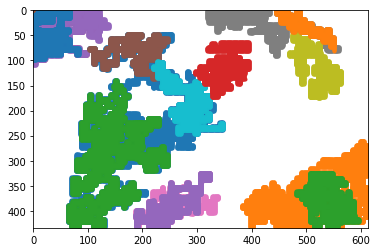

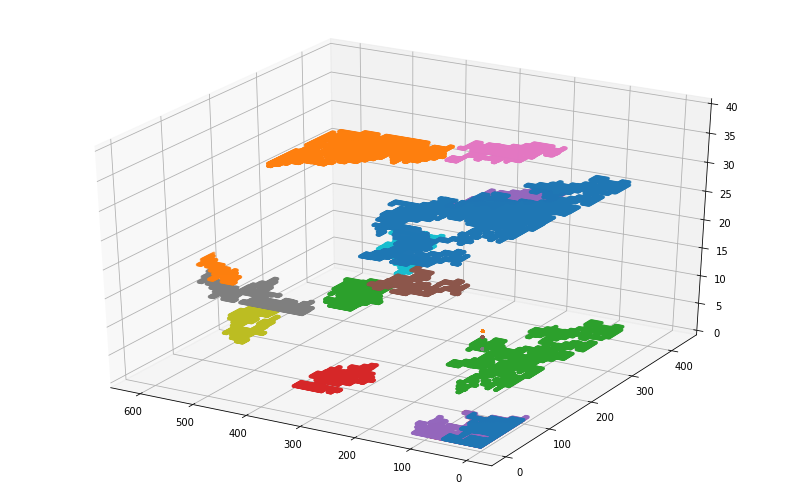

In [ ]:
_, temp_gray = set_image_to_opencv(colgrid_lt)
dim = (gray.shape[1], gray.shape[0])
temp_gray = cv2.resize(temp_gray, dim, interpolation = cv2.INTER_AREA)

lt_regsX, lt_regsY, lt_polys = set_mser_regions(temp_gray, gray,regions_lt)
plot_mser_final_regions(gray,lt_regsX,lt_regsY)

plot_mser_regions_3d(temp_gray,gray,regions_lt)

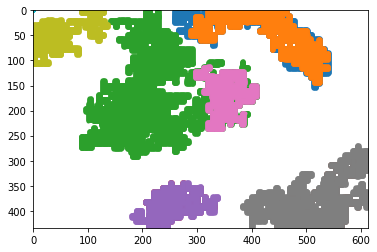

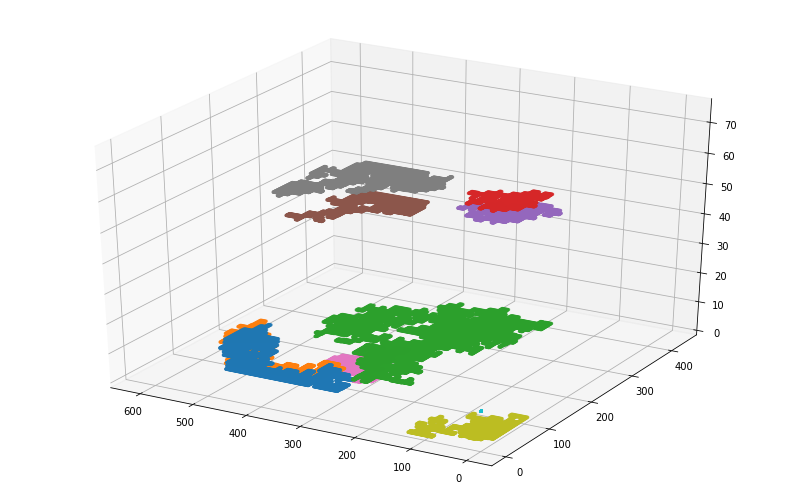

In [ ]:
_, temp_gray = set_image_to_opencv(colgrid_ut)
dim = (gray.shape[1], gray.shape[0])
temp_gray = cv2.resize(temp_gray, dim, interpolation = cv2.INTER_AREA)

ut_regsX, ut_regsY, ut_polys = set_mser_regions(temp_gray, gray,regions_ut)
plot_mser_final_regions(gray,ut_regsX,ut_regsY)
plot_mser_regions_3d(temp_gray,gray,regions_ut)

# SUBSTRACTION

[<shapely.geometry.polygon.Polygon object at 0x7f00ffbedb50>, None, <shapely.geometry.polygon.Polygon object at 0x7f010bc25710>, None, None, None, None, <shapely.geometry.polygon.Polygon object at 0x7f00ffbe8790>, <shapely.geometry.polygon.Polygon object at 0x7f010a3e0050>, None, None, <shapely.geometry.polygon.Polygon object at 0x7f011fe862d0>, None, None, None, <shapely.geometry.polygon.Polygon object at 0x7f00ffd99f50>]


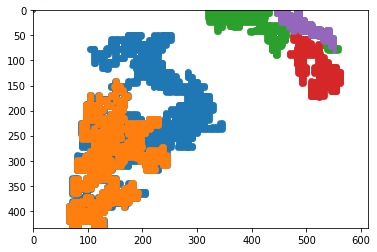

In [ ]:

temp_x = lt_regsX.copy()
temp_y = lt_regsY.copy()
temp_poly = lt_polys.copy()

for i,lt in enumerate(temp_poly[:]):  
  if temp_poly[i] is None:
    continue

  for j,ut in enumerate(ut_polys[:]):
    if lt.intersects(ut):
      percentage = (lt.intersection(ut).area/lt.area) * 100
      if percentage > 70:
        temp_poly[i] = None

print(temp_poly)

#fig, ax = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

xrange = [0, gray.shape[1]]
yrange = [0, gray.shape[0]]

for i,lt in enumerate(temp_poly):
  if lt != None:
    #ring_patch = PolygonPatch(lt)
    #ax.add_patch(ring_patch)
    #xrange = [0, gray.shape[1]]
    #yrange = [0, gray.shape[0]]
    #ax.set_xlim(*xrange)
    #ax.set_ylim(*yrange)
    #ax.invert_yaxis()
    
    ax2.scatter(lt_regsX[i] ,lt_regsY[i], marker='.')
    ax2.set_xlim(*xrange)
    ax2.set_ylim(*yrange)
    ax2.invert_yaxis()

# WITH CO

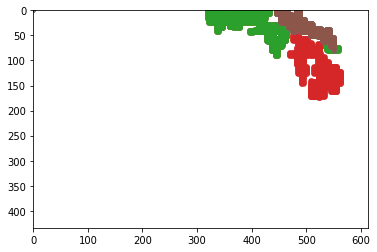

In [ ]:
temp_x = lt_regsX.copy()
temp_y = lt_regsY.copy()
temp_poly1 = temp_poly.copy()

fig, ax = plt.subplots(1,1)

for i,lt in enumerate(temp_poly1[:]):
  if lt is None:
    continue
  
  for j,co in enumerate(co_polys[:]):
    if lt.intersects(co):
      ax.scatter(lt_regsX[i] ,lt_regsY[i], marker='.')
      ax.set_xlim(*xrange)
      ax.set_ylim(*yrange)
      ax.invert_yaxis()

# OLDER FUNCTIONS

In [ ]:
def set_image_levels():
  temp_g_t = global_thresh
  temp_g_t_d = global_thresh_down
  temp_condit = global_thresh_condition
  temp_g_step = global_trhesh_step

  for i in range(start,end):
    if (i==0):
      continue

    print("Threshold", temp_g_t)
    if temp_g_t < 0:
      break

    degree = 0.625 # deg * i
    size = 0.3125 # (degree * size1) /  deg
    thres=(i-20)
    iteration=i
    image_name = DIR_TEST + image_type+"-mesh-"+str(year)+"%02d"%month+"%02d"%day+"-i-0"+str(i)+".png"
    # plot_sequence_images(degree = deg2, size = size2, thres=(i-20), iteration=i, image_type=image_type, day=day )

    lat_g = np.arange(20.,50.,degree)
    lon_g = np.arange(100.,150.,degree)

    #initialization
    colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

    for year in range(2008,2009):
      for month in range(5,6):
        ndays = calendar.mdays[month] + (month==2 and calendar.isleap(year))
        print(year,month,ndays)

        for dd in range (day,day+1):
          
          fname = DIR+'IASIdaily_'+str(year)+"%02d"%month+"%02d"%dd+'.nc'

          #read IASI data in nc archive
          if not(os.path.isfile(fname)):
            continue

          nc = netCDF4.Dataset(fname)
          flg = nc.variables['flag'][:]
          mask1 = (flg == 0)
          
          lat = nc.variables['lat'][mask1]
          lon = nc.variables['lon'][mask1]
          col = nc.variables[image_type][mask1]
          nc.close()

          print("Col",int(col.max() - 5))
          if temp_g_t < int(col.max() - 5) and temp_condit == False:
            temp_g_t = int(col.max() - 10)
            temp_g_step = 5
            temp_condit = True
        
          print('end read nc')
          mask2 = (np.isnan(col) == False) 

          # gridding the data
          for ilat in range(lat_g.shape[0]):
            for ilon in range(lon_g.shape[0]):
              # Grille régulier
              # 25 km
              # 0 25 degrée lattitude et longitude

              # Grille regulier of 0.125 degree
              maskgrid = (lat[:] >= (lat_g[ilat] - size)) & (lat[:] < (lat_g[ilat] + size)) & (lon[:] >= (lon_g[ilon] - size)) & (lon[:] < (lon_g[ilon] + size))
              
              # Defining invalid data
              mask = mask2 & maskgrid

              # Add a media filter for the grill regulier
              isMask = (len(col[mask]) != 0) & (col[mask] >= thres).all()

              if len(col[mask]) != 0:
                median = np.mean(col[mask])
                if median >= temp_g_t:
                  colgrid[ilat,ilon] = median

          # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
          #colgrid = ma.masked_values(colgrid, 0.)

          v_x, v_y = np.meshgrid(lon_g, lat_g)
          gradx, grady = np.gradient(colgrid, edge_order=1)

          data = np.full((colgrid.shape[0], colgrid.shape[1]), colgrid, np.uint8)
          img_bgr = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
          img_rgb = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
          gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
          #gray = cv2.normalize(gray, np.ones((lon_g.shape[0], lat_g.shape[0])) , 0, 255, cv2.NORM_MINMAX )

          scale_percent = 200 #200 # percent of original size
          width = int(gray.shape[1] * scale_percent / 100)
          height = int(gray.shape[0] * scale_percent / 100)
          dim = (width, height)
          gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

          kernel = np.ones((3,3),np.uint8)
          closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations = 2)
          image_close = closing.copy()

          image_large_close = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8), iterations = 2)
          image_holes = image_close.copy()

          # DILATE HOLES
          image_holes = np.where(image_holes == 0, 255, image_holes)
          image_holes = np.where(image_holes != 255, 0, image_holes)
          image_holes_dilate = cv2.morphologyEx(image_holes, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 2)
          image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate)
          
          gray = image_close.copy()
          global_regions.append(gray)

          ## Below code convert image gradient in both x and y direction
          image_laplacian = cv2.Laplacian(gray, cv2.CV_16U, ksize=3) 
          image_laplacian = np.uint8(np.absolute(image_laplacian))
          image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

          global_laplacian.append(image_laplacian)
          ## Below code convert image gradient in x direction
          sobelx= cv2.Sobel(gray, 0, dx=1,dy=0)
          sobelx= np.uint8(np.absolute(sobelx))
          ## Below code convert image gradient in y direction
          sobely= cv2.Sobel(gray, 0, dx=0,dy=1)
          sobely = np.uint8(np.absolute(sobely))
          
          #Create MSER object
          mser = cv2.MSER_create()
          mser.setMaxArea(8000)
          image_mser = gray.copy()

          #detect regions in gray scale image
          image_mser = cv2.cvtColor(image_mser, cv2.COLOR_GRAY2RGB)
          regions, bboxes = mser.detectRegions(image_mser)
          regions = sorted(regions, key=cv2.contourArea, reverse=True)

          for p in regions:
            for k in p:
              cv2.circle(image_mser, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

          #background_image = global_initial_gray.copy()
          #background_image = np.where(background_image == 0, 255, background_image)
          #background_image = np.where(background_image != 255, 0, background_image)
          #background_image = cv2.cvtColor(background_image, cv2.COLOR_GRAY2RGB)
          #regions_background, bboxes_background = mser.detectRegions(background_image)
          #regions_background = sorted(regions_background, key=cv2.contourArea, reverse=True)

          global_mser.append(regions)
          global_contours.append(bboxes)

          image_mser = cv2.bitwise_and(image_mser,image_mser,mask = image_holes_dilate_inv)

          _, labels, _, _ = cv2.connectedComponentsWithStats(image_laplacian, connectivity=8, ltype=cv2.CV_32S) 

          # Map component labels to hue val
          label_hue = np.uint8(170 * labels/np.max(labels))
          blank_ch = 255*np.ones_like(label_hue)
          labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

          # cvt to BGR for display
          labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

          # set bg label to black
          labeled_img[label_hue==0] = 0

          fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(21,15))
          ax0.imshow(gray, cmap="gray")
          ax0.invert_yaxis()
          ax1.imshow(image_laplacian, cmap="gray")
          ax1.invert_yaxis()
          ax2.imshow(image_mser)
          ax2.invert_yaxis()

    temp_g_t -= temp_g_step
    temp_g_t_d -= temp_g_step
    print('end month')

In [ ]:
def plot_mser_levels():
  mix_regions = global_mser.copy()
  mix_boxes = global_contours.copy()
  temp_image = gray.copy()

  background_image = global_initial_gray.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)

  if image_type == "UT":
    starting_point = 4
  else:
    starting_point = 3

  for i, level_regions in enumerate(mix_regions[1:]):
    if len(mix_regions) == 0:
      print("Not data for region ", i)
      break

    #hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in level_regions]
    #for ii, cnt in enumerate(hulls):
    #  for jj, cnt in enumerate(hulls):
    #    if ii >= jj:
    #      continue
    #    
    #    if len(mix_boxes[i]) == 0:
    #      continue
    #      
    #    box_i = mix_boxes[i][ii]
    #    box_j = mix_boxes[i][jj]
    #
    #    tl_i = box_i[:2]
    #    tl_j = box_j[:2]
    #
    #    br_i = tl_i + box_i[2:]
    #    br_j = tl_j + box_j[2:]
    #
    #    tl = np.maximum(tl_i, tl_j)
    #    br = np.minimum(br_i, br_j)
    #    intersected_rect = br - tl

    #    intersection = np.prod(intersected_rect) if intersected_rect[0] > 0 and intersected_rect[1] > 0 else 0
    #    union = np.prod(box_i[2:]) + np.prod(box_j[2:]) - intersection
    #    iou = intersection / union

    #    #if (iou > 0.5):
    #    #  print("HIs",iou, "id", i, "subreg", ii, "subsub", jj)
    #    #  #del level_regions[i]

    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    fig3 = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')

    for j,r in enumerate(level_regions):
      region = list()
      hull = cv2.convexHull(r)

      for h in hull:
          region.append(h[0].tolist())

      region.append(region[0])
      poly = Polygon(region)

      line = LineString(region)
      x, y = line.xy

      coord_x = int(line.centroid.x)
      coord_y = int(line.centroid.y)

      value_pixel = temp_image[coord_y, coord_x]
      z = np.full(len(x),value_pixel)

      xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
      ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
      zs = np.full(len(xs),value_pixel) #  [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

      xrange = [0, gray.shape[1]]
      yrange = [0, gray.shape[0]]
      zrange = [0, colgrid.max()]

      ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
      ax0.set_xlim(*xrange)
      ax0.set_ylim(*yrange)
      ax0.set_title('Region ' + str(i))
      #ax0.legend()

      ax1.plot(x, y, label='Region ' + str(j))
      ax1.set_xlim(*xrange)
      ax1.set_ylim(*yrange)
      ax1.set_title('ConvexHull ' + str(i))
      #ax1.legend()

      #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
      #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
      #ax = gs.plot(marker='.', color='red', markersize=1)
      #ax.set_xlim(*xrange)
      #ax.set_ylim(*yrange)

      ax.scatter(xs,ys,zs, marker='.')
      ax.set_zlim(*zrange)
      

NameError: ignored

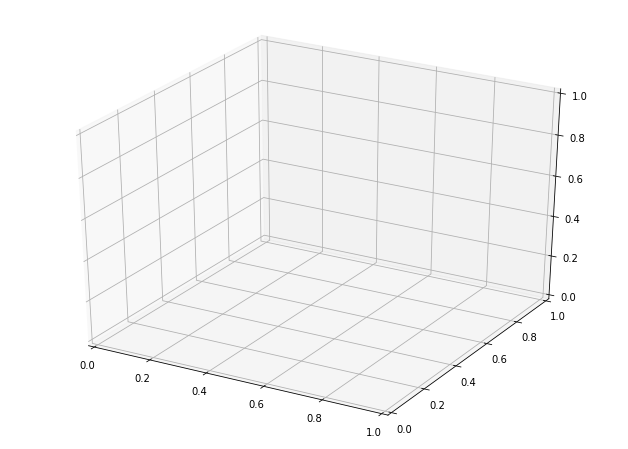

In [ ]:
#fig2, ax0 = plt.subplots(1,1)
f3d = plt.figure(figsize=(11,8))
ax3d = plt.axes(projection='3d')

for i, level_regions in enumerate(mix_regions):
    print("Region " + str(i) + " of " + str(len(mix_regions))+ " started.")
    for r in level_regions:
        region = list()
        temp = np.zeros(black_image.shape, np.uint8)
        hull = cv2.convexHull(r)
  
        for h in hull:
            region.append(h[0].tolist())

        region.append(region[0])
        poly = Polygon(region)

        xrange = [0, black_image.shape[1]]
        yrange = [0, black_image.shape[0]]

        line = LineString(poly.exterior)
        x, y = line.xy

        coord_x = int(line.centroid.x)
        coord_y = int(line.centroid.y)

        value_pixel = gray[coord_y, coord_x]

        x_ = [pnt[0] for pnt in r]
        y_ = [pnt[1] for pnt in r]
        z_ = np.full(len(x_),value_pixel)

        z = np.full(len(x),value_pixel)
        # Data for a three-dimensional line
        ax3d.plot3D(x, y, z, label="Gray value: " +str(value_pixel) )
        #ax3d.scatter(x_, y_, z_)
        #leg = ax3d.legend()
    print("Region " + str(i) + " done.")
print("Done :)")

In [ ]:
## CALCULATE THE BACKGROUND AT EACH LEVEL AND THE FINAL GRAY IMAGE

test_global_regs = global_regions.copy()



i = 0
for image in range(len(test_global_regs) - 1):
  f, (ax1) = plt.subplots(1, 1, figsize = (11,8))

  if i == 0:
    image1 = test_global_regs[i]
  else:
    image1 = image3
  image2 = test_global_regs[i + 1]
  image3 = cv2.addWeighted(image1,1,image2,.7,0)

  combination_regions = image3.copy()
  current_region = test_global_regs[i]

  background_image = current_region.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)

  
  ax1.imshow(combination_regions, cmap="gray")
  ax1.invert_yaxis()

  # f.savefig(DIR_TEST + "/05-03/" + image_type + "/" + image_type + "_combination_" + str(year) + "-" + str(month) + "-" + str(day) + "_deg_" + str(degree) + "_i_0" + str(i) + ".png", pad_inches=.01)

  i += 1

In [ ]:
mser1 = cv2.MSER_create()
image_background = background_image.copy() # background
image_pollution = combination_regions.copy() # foreground
mser1.setMaxArea(8000)

image_pollution = cv2.cvtColor(image_pollution, cv2.COLOR_GRAY2RGB)
regions_pollution, bboxes4 = mser1.detectRegions(image_pollution)
regions_pollution = sorted(regions_pollution, key=cv2.contourArea, reverse=True)

temp = np.zeros(image_pollution.shape, np.uint8)

for p in regions_pollution:
  for k in p:
    cv2.circle(image_pollution, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)


image_pollution = cv2.bitwise_and(image_pollution,image_pollution,mask = image_holes_dilate_inv)

f, (ax0) = plt.subplots(1,1, figsize=(11,8))
ax0.imshow(image_pollution)
ax0.invert_yaxis()
#ax1.imshow(combination_regions, cmap="gray")
#ax1.invert_yaxis()

In [ ]:
temp_image = combination_regions.copy()

background_image = global_initial_gray.copy()
background_image = np.where(background_image == 0, 255, background_image)
background_image = np.where(background_image != 255, 0, background_image)

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
fig3 = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

for j,r in enumerate(regions_pollution):
  region = list()
  hull = cv2.convexHull(r)

  for h in hull:
      region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  value_pixel = temp_image[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  zs =  np.full(len(xs),value_pixel) #    [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

  xrange = [0, gray.shape[1]]
  yrange = [0, gray.shape[0]]
  zrange = [0, 255]

  ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
  ax0.set_xlim(*xrange)
  ax0.set_ylim(*yrange)
  ax0.set_title('Region ')
  #ax0.legend()

  ax1.plot(x, y, label='Region ' + str(j))
  ax1.set_xlim(*xrange)
  ax1.set_ylim(*yrange)
  ax1.set_title('ConvexHull ')
  #ax1.legend()

  #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
  #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
  #ax = gs.plot(marker='.', color='red', markersize=1)
  #ax.set_xlim(*xrange)
  #ax.set_ylim(*yrange)

  ax.scatter(xs,ys,zs, marker='.')
  ax.set_zlim(*zrange)
  

In [ ]:
fig = plt.figure()
f3d = plt.figure(figsize=(11,8))
ax3d = plt.axes(projection='3d')

for c in regions:
  region = list()
  temp = np.zeros(combination_regions.shape, np.uint8)
  hull = cv2.convexHull(c)
  
  for h in hull:
    region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  ax = fig.add_subplot(111)
  ring_patch = PolygonPatch(poly)
  ax.add_patch(ring_patch)
  xrange = [0, combination_regions.shape[1]]
  yrange = [0, combination_regions.shape[0]]
  ax.set_xlim(*xrange)
  ax.set_ylim(*yrange)

  value_pixel = combination_regions[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  # Data for a three-dimensional line
  ax3d.plot3D(x, y, z, label="Gray value: " +str(value_pixel) )
  leg = ax3d.legend()

In [ ]:
img = combination_regions.copy()
iou_th = 0.95

m_a_t = int(0.1 * np.pi * (img.shape[0] /2)**2)

print(m_a_t)

mser = cv2.MSER_create(_delta=10, _min_area=100, _max_area=10000, _max_variation=0.1)
regions, bboxes = mser.detectRegions(img)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

# Debug plot
img_ = img.copy()
cv2.polylines(img_, hulls, 1, (255, 0, 0), thickness=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_)
ax.set_title('MSER with overlapping regions')

size_dict = {k: len(region) for k, region in enumerate(regions)}

# Cull overlapping blobs
graph = nx.Graph()
graph.add_nodes_from(range(len(hulls)))

for i, cnt in enumerate(hulls):
    for j, cnt in enumerate(hulls):
        if i >= j:
            continue
        box_i = bboxes[i]
        box_j = bboxes[j]
        tl_i = box_i[:2]
        tl_j = box_j[:2]

        br_i = tl_i + box_i[2:]
        br_j = tl_j + box_j[2:]

        tl = np.maximum(tl_i, tl_j)
        br = np.minimum(br_i, br_j)
        intersected_rect = br - tl
        intersection = np.prod(intersected_rect) if intersected_rect[0] > 0 and intersected_rect[1] > 0 else 0
        union = np.prod(box_i[2:]) + np.prod(box_j[2:]) - intersection
        iou = intersection / union

        if iou > iou_th:
            graph.add_edge(i, j, iou=iou)

# make list of unique regions - pick the smallest region
#trees = list(nx.connected_components(graph))
trees = (graph.subgraph(c) for c in nx.connected_components(graph))

unique_blobs = []
for tree in trees:
    # Choose the smallest region
    smallest_idx = None
    smallest_blob = np.inf
    for node in tree.nodes():
        if size_dict[node] < smallest_blob:
            smallest_blob = size_dict[node]
            smallest_idx = node

        unique_blobs.append(smallest_idx)
unique_blobs = unique_blobs
hulls = [hulls[k] for k in unique_blobs]
regions = [regions[k] for k in unique_blobs]
bboxes = [bboxes[k] for k in unique_blobs]
size_dict = {k: len(region) for k, region in enumerate(regions)}

# debug plot
img_ = img.copy()
cv2.polylines(img_, hulls, 1, (255, 0, 0), thickness=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_)
ax.set_title('MSER with unique regions')
